# Webinar - airline delays

W trakcie webinaru poznamy _Excelowy_ odpowiednik w Pythonie czyli Pandas. W arkuszu zapoznamy się:
- jak zaczytać plik `csv`, z którym arkusz kalkulacyjny po prostu by nie dał rady,
- przeglądnąć dane i sprawdzić czy nie ma oczywistych błędów,
- dokonać elementranej analizy eksporacyjnej.

Jako studium przypadkum przyjmiemy, że chcemy znaleźć czynnik (zmienną), która odpowiada za to, że samoloty łapią opóźnienie od rozkładu.

In [1]:
import os
import pandas as pd

In [2]:
def get_month_from_filename(file_name: str) -> int:
    """
    Funkcja, która na podstawie nazwy pliku zwraca miesiąc, z którego dane pochodzą
    """
    month = file_name[-6:-4]
    return month

In [3]:
def read_raw_csv(file_name: str, month: int) -> pd.DataFrame:
    df = pd.read_csv(file_name)
    df["file_month"] = month

    return df

### Wczytanie poszczególnych plików do jednej zbiorczej ramki
Najpierw zapiszemy sobie wszystko do słownika, gdzie kluczem będzie numer miesiąca a potem wszystko skleimy w jedną, dużą

In [4]:
data = {}
data_dir = "./data/raw"

for file in os.scandir(data_dir):
    if file.name == '.gitkeep':
        continue
    
    file_path = os.path.normpath(os.path.join(data_dir, file.name))

    month = get_month_from_filename(file.name)
    data[month] = read_raw_csv(file_path, month)


Złączenie poszczególnych ramek w jedną

In [5]:
df_raw = pd.concat([x for _, x  in data.items()])

Tworzymy ramkę, na której będziemy pracować do końca notebook'a

In [6]:
df = df_raw.copy()  # skopiowanie danych do innej ramki, na wszelki wypadek
df.head()  # wyświetlenie zawartości tabelki

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,...,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,file_month
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,...,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,...,32.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,...,39.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01
3,1,9,3,9E,N840AY,3280,10397,ATL,"Atlanta, GA",11150,...,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01
4,1,10,4,9E,N8969A,3280,10397,ATL,"Atlanta, GA",11150,...,41.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01


In [7]:
df.columns = [x.lower() for x in df.columns]  # zmieniamy nazwy kolumn z UPPER_CASE na upper_case (według uzania)
df.drop(columns="unnamed: 32", inplace=True)  # usuwamy jedną nadmiarową kolumnę

Wybieramy podzbiór kolumn, za pomocą których będziemy analizować dane

In [8]:
columns_subset = [
    "month",
    "day_of_month",
    "day_of_week",
    "dep_del15",
    "origin_city_name",
    "dest_city_name",
    "cancelled"
]

df = df[columns_subset]  # redukcja liczby kolumn
df.rename(columns={"dep_del15": "is_delayed"}, inplace=True)  # zmiana nazwy na bardziej opisową

In [9]:
df.head()

,month,day_of_month,day_of_week,is_delayed,origin_city_name,dest_city_name,cancelled
0,1,6,7,0.0,"Atlanta, GA","Columbus, GA",0.0
1,1,7,1,0.0,"Atlanta, GA","Columbus, GA",0.0
2,1,8,2,0.0,"Atlanta, GA","Columbus, GA",0.0
3,1,9,3,0.0,"Atlanta, GA","Columbus, GA",0.0
4,1,10,4,0.0,"Atlanta, GA","Columbus, GA",0.0


# Przegląd danych

In [10]:
df['is_delayed'].unique()

array([ 0.,  1., nan])

In [11]:
df['month'].unique()  # sprawdzenie mc'y dostępnych w ramce

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [12]:
df.groupby(by=['month'])['day_of_month'].max()

month
1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: day_of_month, dtype: int64

# Analiza eksploracyjna

## Analiza po miesiącach

In [13]:
delayed_by_month = df.groupby(by=['month'])['is_delayed'].mean()

<AxesSubplot:title={'center':'Deletion rate by month'}, xlabel='Month', ylabel='Rate'>

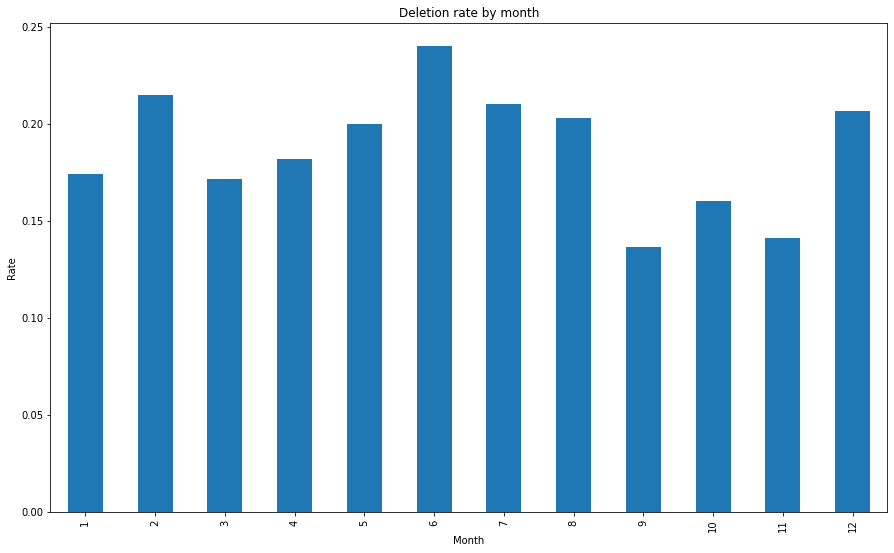

In [14]:
delayed_by_month.plot(
    kind="bar",
    title="Deletion rate by month",
    xlabel="Month",
    ylabel="Rate",
    figsize=(15, 9))

### Grupujemy miesiące na wakacyjne lub nie 
> bardzo luźno stwierdzone

In [15]:
df['is_holiday_month'] = 0

holiday_months = [2, 6, 7, 8, 12]
is_holiday_month = df['month'].isin(holiday_months)
df.loc[is_holiday_month, 'is_holiday_month'] = 1

df[['month', 'is_holiday_month']].drop_duplicates()

,month,is_holiday_month
0,1,0
0,2,1
0,3,0
0,4,0
0,5,0
0,6,1
0,7,1
0,8,1
0,9,0
0,10,0


<AxesSubplot:title={'center':'Dele rate by month'}, xlabel='Is holiday season', ylabel='Rate'>

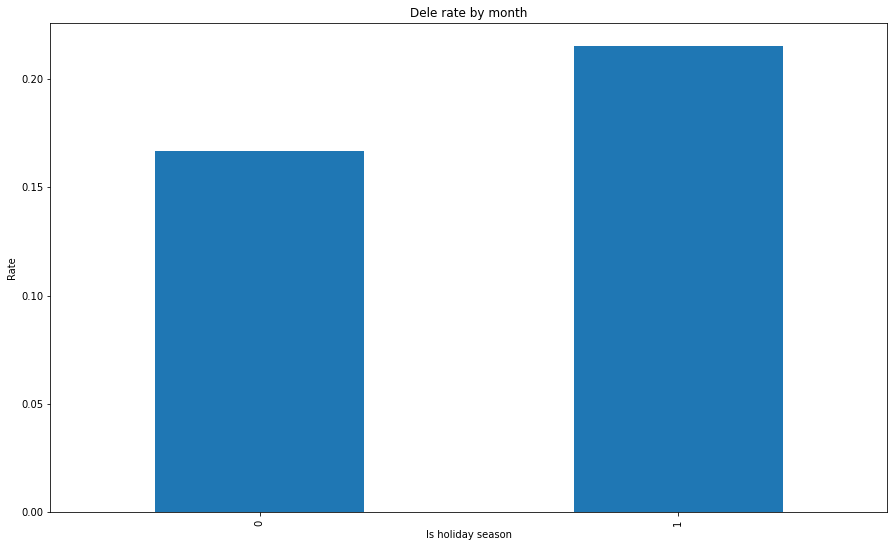

In [16]:
delayed_by_month = df.groupby(by=['is_holiday_month'])['is_delayed'].mean()
delayed_by_month.plot(
    kind="bar",
    title="Dele rate by month",
    xlabel="Is holiday season",
    ylabel="Rate",
    figsize=(15, 9))

# Analiza według dnia tygodnia

Przy użyciu tabeli przestawnej (pivot tale)

In [17]:
pt = df.pivot_table(
    columns='month', 
    index='day_of_week', 
    values='is_delayed', 
    aggfunc='mean',
    margins=True)

pt.style.background_gradient(cmap="Blues")

month,1,2,3,4,5,6,7,8,9,10,11,12,All
day_of_week,,,,,,,,,,,,,
1,0.176532,0.224741,0.158959,0.233105,0.191381,0.253213,0.218369,0.181925,0.134631,0.163941,0.149755,0.250122,0.195919
2,0.159540,0.205140,0.133505,0.136764,0.186516,0.229051,0.198951,0.216454,0.130726,0.134384,0.152916,0.197932,0.172981
3,0.180140,0.232130,0.148382,0.126068,0.176749,0.234881,0.200905,0.217055,0.127281,0.156739,0.145126,0.194234,0.178318
4,0.197573,0.242580,0.174171,0.167594,0.244330,0.244740,0.225515,0.235308,0.163040,0.187944,0.140392,0.178780,0.201901
5,0.172066,0.232064,0.197003,0.228862,0.203144,0.216809,0.208057,0.209738,0.164910,0.193617,0.151536,0.186678,0.196822
6,0.146455,0.164140,0.187171,0.172824,0.176796,0.227535,0.202682,0.160029,0.104117,0.111744,0.135677,0.198152,0.167444
7,0.177158,0.189362,0.188872,0.201996,0.206383,0.269249,0.218829,0.193986,0.126240,0.163659,0.109607,0.224501,0.190491
All,0.174281,0.214910,0.171492,0.181798,0.199640,0.239991,0.210091,0.203157,0.136510,0.160301,0.140985,0.206621,0.186804


# Analiza według liczby lotów danego dnia

In [18]:
df['month_day'] = df['month'].apply(lambda x: str(x).zfill(2)) + '-' + df['day_of_month'].apply(lambda x: str(x).zfill(2))
df['month_day'].head()

0    01-06
1    01-07
2    01-08
3    01-09
4    01-10
Name: month_day, dtype: object

In [19]:
df_by_month_day = df.groupby(by=["month_day"], as_index=False).\
    agg(avg=('is_delayed', 'mean'), cnt=('is_delayed', 'count'))
df_by_month_day.head()

,month_day,avg,cnt
0,01-01,0.211636,17875
1,01-02,0.251039,20216
2,01-03,0.192151,19391
3,01-04,0.134321,19498
4,01-05,0.159513,16682


<AxesSubplot:xlabel='month_day', ylabel='Deley rate'>

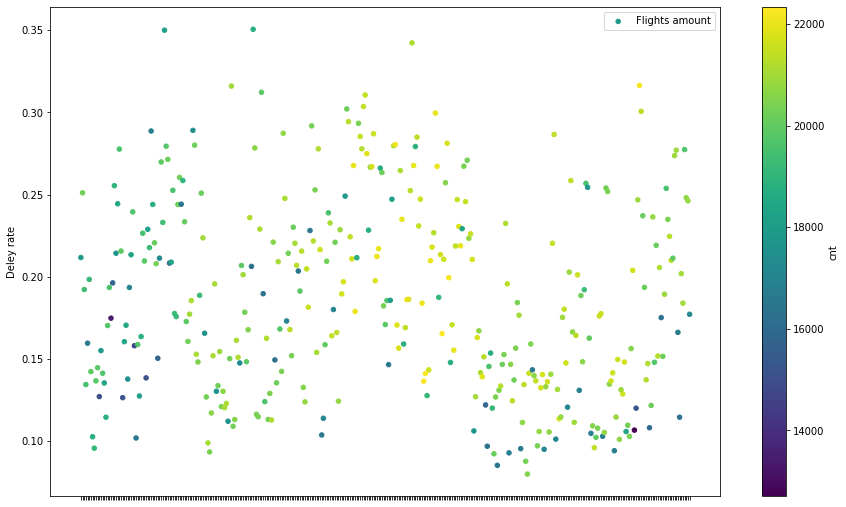

In [20]:
df_by_month_day.plot(
        kind='scatter', 
        x="month_day", 
        y="avg",
        c="cnt",
        figsize=(15, 9),
        colormap='viridis',
        ylabel="Deley rate",
        label="Flights amount"
        )

<AxesSubplot:xlabel=' Flights amount', ylabel='Deley rate'>

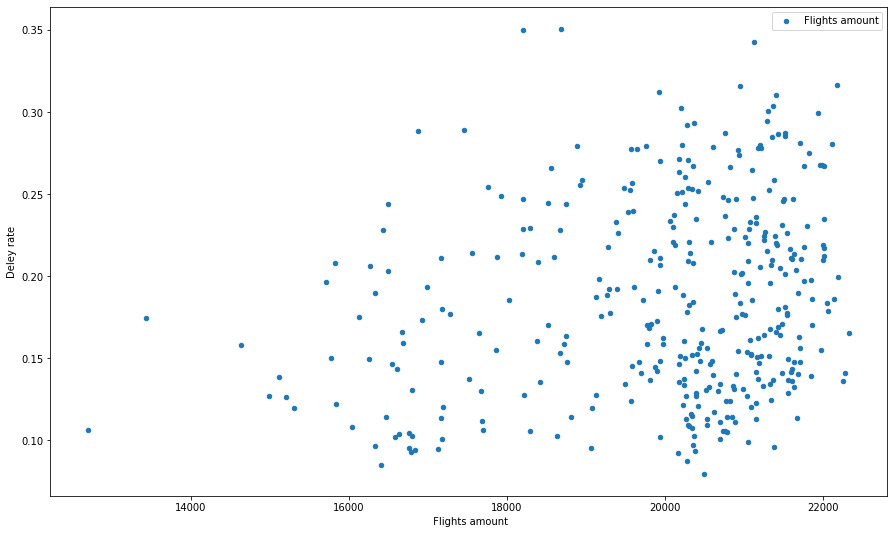

In [21]:
df_by_month_day.plot(
        kind='scatter', 
        x="cnt", 
        y="avg",
        # c="cnt",
        figsize=(15, 9),
        # colormap='viridis',
        ylabel="Deley rate",
        xlabel=" Flights amount",
        label="Flights amount"
        )

# Analiza przy pomocy trasy (dest <-> source airport)

In [22]:
df_by_route = df.groupby(
    by=['origin_city_name', 'dest_city_name'],
    as_index=False)['is_delayed'].mean()
df_by_route.head()

,origin_city_name,dest_city_name,is_delayed
0,"Aberdeen, SD","Minneapolis, MN",0.137978
1,"Abilene, TX","Dallas/Fort Worth, TX",0.173232
2,"Adak Island, AK","Anchorage, AK",0.387755
3,"Aguadilla, PR","Fort Lauderdale, FL",0.188312
4,"Aguadilla, PR","New York, NY",0.261283


<AxesSubplot:xlabel='origin_city_name', ylabel='dest_city_name'>

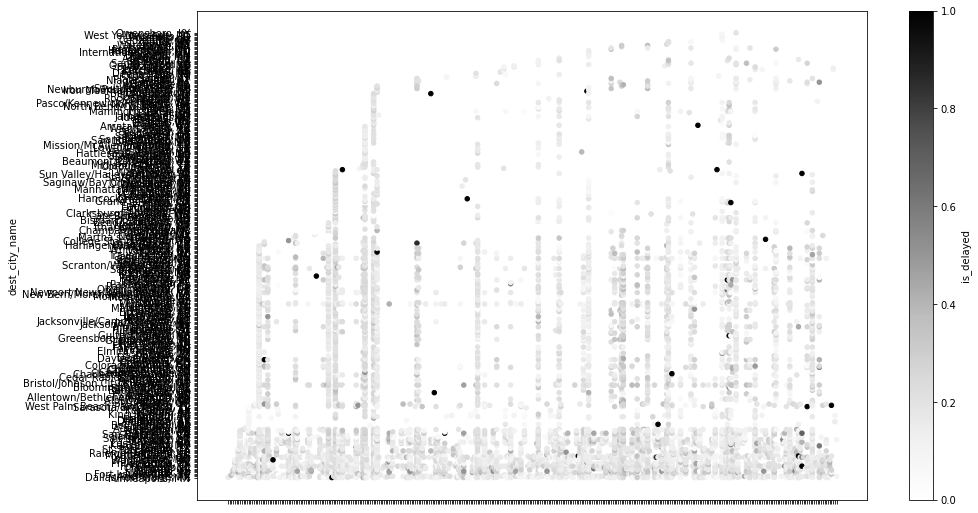

In [23]:
df_by_route.plot(
    kind='scatter',
    x='origin_city_name',
    y='dest_city_name',
    c='is_delayed',
    figsize=(15, 9)
)